In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url_data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [3]:
# get the data
df = pd.read_csv(url_data)

In [4]:
# normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [5]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [6]:
# filter columns
filtered_columns = ['ram','storage', 'screen', 'final_price']
df = df[filtered_columns]

In [7]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [8]:
df.shape

(2160, 4)

### ***EDA***

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2160 non-null   int64  
 1   storage      2160 non-null   int64  
 2   screen       2156 non-null   float64
 3   final_price  2160 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


In [10]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


In [11]:
# check for missing values
df.isnull().any()

ram            False
storage        False
screen          True
final_price    False
dtype: bool

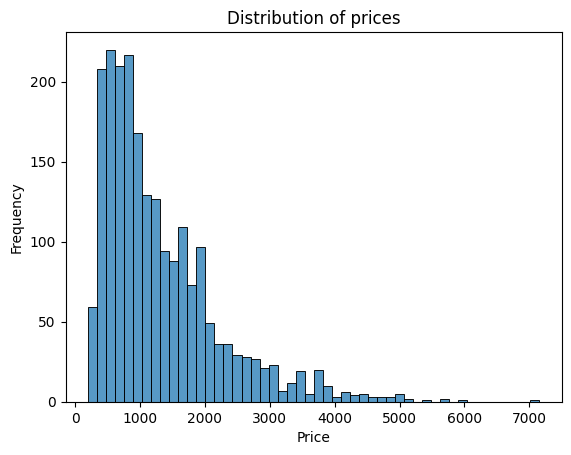

In [12]:
#  check final price distribution
sns.histplot(df.final_price, bins=50)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show();

`final_price ` variable has a tail distribution, but not long enough to be trabnsformed into a normal distribution

### ***Q 1***

There's one column with missing values. What is it?

In [13]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [14]:
df.columns[df.isnull().any()].values[0]

'screen'

#### ***Answer Q1:*** Screen column

### ***Q 2***   
What's the median (50% percentile) for variable `'ram'`?

In [15]:
# median 
print(f'Median for ram: {df.ram.median()}')

# percentile 50
print(f'Percentile 50 for ram: {df.ram.quantile(0.5)}')

Median for ram: 16.0
Percentile 50 for ram: 16.0


#### ***Answer Q2:*** 16

#### Prepare and split data

- Shuffle the dataset (the filtered one you created above), use seed 42.

- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [16]:
def shuffle_and_split_data(df, seed):
    n_total = len(df)
    n_val = int(0.2 * n_total)   
    n_test = int(0.2 * n_total)  
    n_train = n_total - (n_val + n_test)
    
    # Shuffle del índice
    idx = np.arange(n_total)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_shuffled = df.iloc[idx]
    df_train = df_shuffled.iloc[:n_train].reset_index(drop=True)
    df_val = df_shuffled.iloc[n_train:n_train+n_val].reset_index(drop=True)
    df_test = df_shuffled.iloc[n_train+n_val:].reset_index(drop=True)

    return df_train, df_val, df_test

In [17]:
# get X
df_train, df_val, df_test = shuffle_and_split_data(df=df, seed=42)

In [18]:
df_train.head()

,ram,storage,screen,final_price
0,32,1000,15.6,1123.29
1,4,64,14.1,201.05
2,32,1000,14.0,997.74
3,16,512,13.3,1016.00
4,32,1000,16.0,2739.00


In [19]:
len(df_train) + len(df_val) + len(df_test)  == df.shape[0] 

True

In [20]:
# get y
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

## delete target from the data
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

### ***Q3***

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [21]:
# linear regression function
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [22]:
## prepare data
selected_columns = ['ram','storage', 'screen']

def prepare_X(df, fillna_value):
    df_num = df[selected_columns]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

In [23]:
## RMSE function
def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [24]:
mean = df_train.screen.mean()

## x_train missing values
X_train_mean = prepare_X(df_train, fillna_value=mean)
w_0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

In [25]:
## x_val missing values
X_val_mean = prepare_X(df_val, fillna_value=mean)
y_pred_val_mean = w_0_mean + X_val_mean.dot(w_mean) 

In [26]:
print('RMSE:', np.round(rmse(y_val, y_pred_val_mean),2))

RMSE: 600.27


In [27]:
## fill missing values with 0
# x_train missing values
X_train_zero = prepare_X(df_train, fillna_value=0)
w_0_zero, w_zero = train_linear_regression(X_train_zero, y_train)

In [28]:
## x_val missing values
X_val_zero = prepare_X(df_val, fillna_value=0)
y_pred_val_zero = w_0_zero + X_val_zero.dot(w_zero)  

In [29]:
print('RMSE', np.round(rmse(y_val, y_pred_val_zero),2))

RMSE 597.36


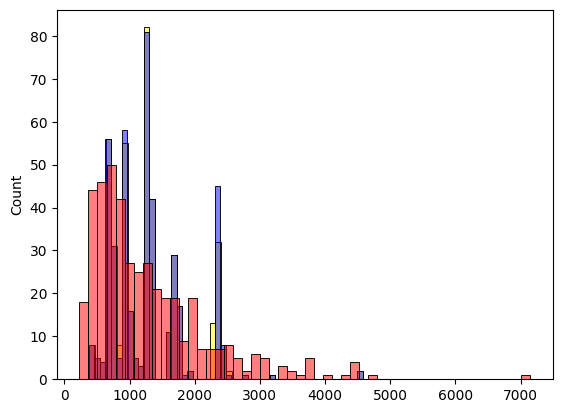

In [30]:
sns.histplot(y_pred_val_mean, alpha=.5, bins=50, color='yellow')
sns.histplot(y_pred_val_zero, alpha=.5, bins=50, color='blue')
sns.histplot(y_val, alpha=.5, bins=50, color='red');

#### ***Answer Q3:*** With zero

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- 10
- 100

In [31]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

***remember to use obtained values form missing values with 0***

In [32]:
r_values = [0, 0.01, 0.1, 1, 5, 10, 100]

result = {}

for r in r_values:
    w_0_zero_reg, w_reg = train_linear_regression_reg(X_train_zero, y_train, r=r)
    y_null_reg_val = w_0_zero_reg + X_val_zero.dot(w_reg)
    rmse_zero_reg = rmse(y_val, y_null_reg_val)
    result[r] = np.round(rmse_zero_reg,2)
    
    print(f"RMSE: {rmse_zero_reg:.2f}, r_value: {r}")

RMSE: 597.36, r_value: 0
RMSE: 597.36, r_value: 0.01
RMSE: 597.35, r_value: 0.1
RMSE: 597.21, r_value: 1
RMSE: 597.01, r_value: 5
RMSE: 597.06, r_value: 10
RMSE: 597.90, r_value: 100


#### ***Answer Q4:*** r = 5, is the lowest value

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- 29.176
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ram      1296 non-null   int64  
 1   storage  1296 non-null   int64  
 2   screen   1293 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 30.5 KB


In [34]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_list = []

for seed in seed_values:
    df_train, df_val, df_test = shuffle_and_split_data(df, seed=seed)

    y_train = df_train['final_price'].values
    y_val = df_val['final_price'].values
    y_test = df_test['final_price'].values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train_zero = prepare_X(df_train, fillna_value=0)
    w_0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
    
    X_val_zero = prepare_X(df_val, fillna_value=0)
    y_val_zero = w_0_zero + X_val_zero.dot(w_zero)
    
    rmse_val = np.round(rmse(y_val, y_val_zero), 2)
    rmse_list.append(rmse_val)

    print(f"Seed: {seed}, w_0: {w_0_zero:.2f}, RMSE: {rmse_val}")

Seed: 0, w_0: 547.57, RMSE: 565.45
Seed: 1, w_0: 594.42, RMSE: 636.8
Seed: 2, w_0: 649.47, RMSE: 588.96
Seed: 3, w_0: 571.95, RMSE: 597.81
Seed: 4, w_0: 629.39, RMSE: 571.96
Seed: 5, w_0: 580.76, RMSE: 573.24
Seed: 6, w_0: 783.77, RMSE: 647.34
Seed: 7, w_0: 376.44, RMSE: 550.44
Seed: 8, w_0: 572.89, RMSE: 587.33
Seed: 9, w_0: 663.38, RMSE: 576.1


In [35]:
np.round(np.std(rmse_list),3)

np.float64(29.176)

#### ***Answer Q5 What's the value of std?:*** 29.176

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- 608.60
- 618.60
- 628.60


In [36]:
seed = 9

df_train, df_val, df_test = shuffle_and_split_data(df=df, seed=seed)

df_train_val = pd.concat([df_train, df_val]).reset_index(drop=True)

y_train_val = df_train_val['final_price'].values
y_test = df_test['final_price'].values

del df_train_val['final_price']
del df_test['final_price']


In [37]:
X_train_val_zero = prepare_X(df_train_val, fillna_value=0)
w_0_train_val_zero, w_train_val_zero = train_linear_regression_reg(X_train_val_zero, y_train_val, r=0.001)

X_test_zero = prepare_X(df_test, fillna_value=0)
y_pred_test_zero = w_0_train_val_zero + X_test_zero.dot(w_train_val_zero)

rmse_test = np.round(rmse(y_test, y_pred_test_zero), 2)
print(f"RMSE: {rmse_test}")

RMSE: 608.61
